In [1]:
import kagglehub
# Download the dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

100%|██████████| 6.90G/6.90G [04:47<00:00, 25.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1


In [2]:
!pip install kagglehub librosa tensorflow scikit-learn joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
sample_rate = 22050  # Audio sampling rate
n_mfcc = 40  # Number of MFCCs
test_size = 0.2  # Fraction for testing
validation_fraction = 0.125  # Fraction of training data for validation
batch_size = 32  # Training batch size
epochs = 30  # Number of training epochs

# Download the Kaggle dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

# Additional train sounds path
new_train_dir = '/content/drive/MyDrive/train_audio_clips'  # Your additional train audio directory

# Combine new train data into Kaggle dataset
def combine_new_train_data(data_dir, new_train_dir):
    train_label_path = os.path.join(data_dir, "train")
    if not os.path.exists(train_label_path):
        os.makedirs(train_label_path)
    for file in os.listdir(new_train_dir):
        source_path = os.path.join(new_train_dir, file)
        destination_path = os.path.join(train_label_path, file)
        if not os.path.exists(destination_path):  # Avoid overwriting
            shutil.copy(source_path, destination_path)  # Copy files instead of renaming

combine_new_train_data(path, new_train_dir)

# Load and preprocess the combined dataset
def load_data(data_dir):
    X = []  # Features
    y = []  # Labels
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    audio, _ = librosa.load(file_path, sr=sample_rate)
                    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
                    mfcc_mean = np.mean(mfcc.T, axis=0)
                    X.append(mfcc_mean)
                    # Assuming any label besides 'train' should be labeled as 'not_train'
                    if label == 'train':
                        y.append('train')
                    else:
                        y.append('not_train')
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y)

# Load data
X, y = load_data(path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_fraction, random_state=42)

# Build the neural network model for binary classification
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Single output neuron with sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Binary cross-entropy loss
    return model

# Build and train the model
input_shape = (X_train.shape[1],)
model = build_model(input_shape)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('audio_train_classifier_model.h5')

# Batch prediction
def batch_classify_audio(file_paths, model, label_encoder):
    for file_path in file_paths:
        classify_audio(file_path, model, label_encoder)

# Classify a new audio file
def classify_audio(file_path, model, label_encoder):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_mean = np.expand_dims(mfcc_mean, axis=0)
        prediction = model.predict(mfcc_mean)
        predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
        print(f"File: {file_path} | Predicted Label: {predicted_label[0]}")
    except Exception as e:
        print(f"Error classifying {file_path}: {e}")

# Example usage
test_audio_files = ['/content/clip_20.wav', '/content/clip_20.wav']  # Add test audio files
batch_classify_audio(test_audio_files, model, label_encoder)


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8407 - loss: 1.5108 - val_accuracy: 0.9835 - val_loss: 0.0635
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9495 - loss: 0.1532 - val_accuracy: 0.9861 - val_loss: 0.0439
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9707 - loss: 0.0871 - val_accuracy: 0.9904 - val_loss: 0.0267
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9794 - loss: 0.0676 - val_accuracy: 0.9930 - val_loss: 0.0200
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9857 - loss: 0.0472 - val_accuracy: 0.9948 - val_loss: 0.0162
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9886 - loss: 0.0339 - val_accuracy: 0.9948 - val_loss: 0.0127
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9908 - loss: 0.0296 - val_accuracy: 0.9957 - val_loss: 0.0121
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0291 - val_accuracy: 0.

Test Accuracy: 99.39%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
File: /content/clip_35.wav | Predicted Label: train
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
File: /content/aug_clip_20.wav | Predicted Label: not_train


<ipython-input-4-5d3a40e4aa47>:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
<ipython-input-4-5d3a40e4aa47>:123: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


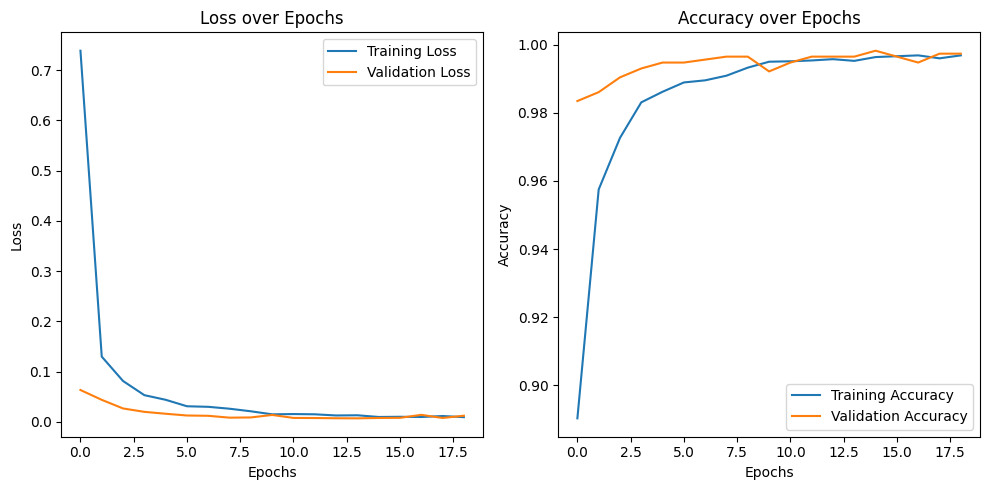

In [5]:
def plot_training_history(history):
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

   not_train       0.99      1.00      1.00      1888
       train       0.99      0.97      0.98       412

    accuracy                           0.99      2300
   macro avg       0.99      0.99      0.99      2300
weighted avg       0.99      0.99      0.99      2300



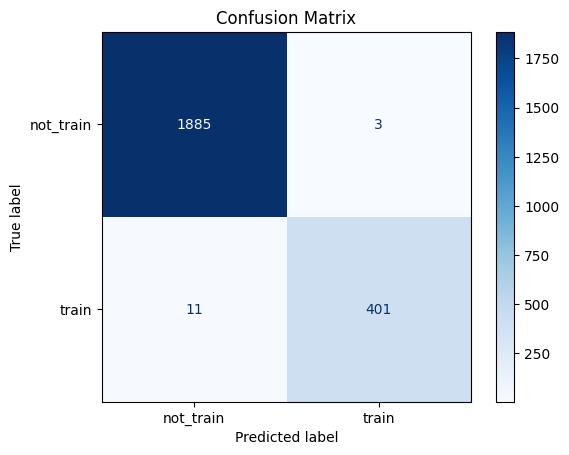

True Positives (TP): 401
True Negatives (TN): 1885
False Positives (FP): 3
False Negatives (FN): 11


<ipython-input-6-537b3d178a38>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


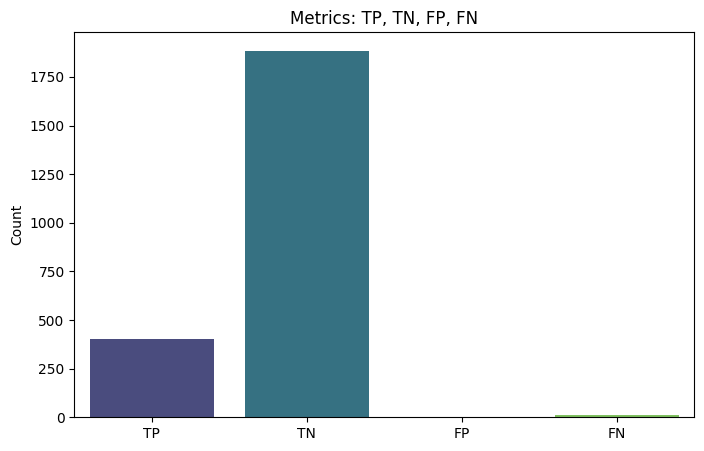

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the test set
y_pred_probs = model.predict(X_test)  
y_pred = (y_pred_probs > 0.5).astype(int)  

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Print TP, TN, FP, FN
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Visualize TP, TN, FP, FN as a bar chart
metrics = ['TP', 'TN', 'FP', 'FN']
values = [TP, TN, FP, FN]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title("Metrics: TP, TN, FP, FN")
plt.ylabel("Count")
plt.show()


In [7]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,140 (106.02 KB)

None


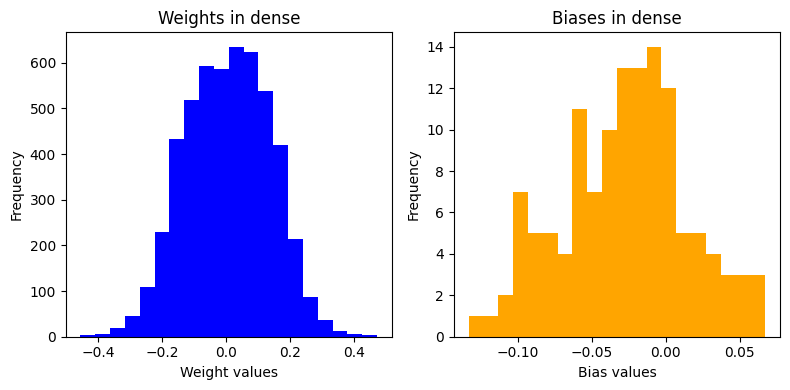

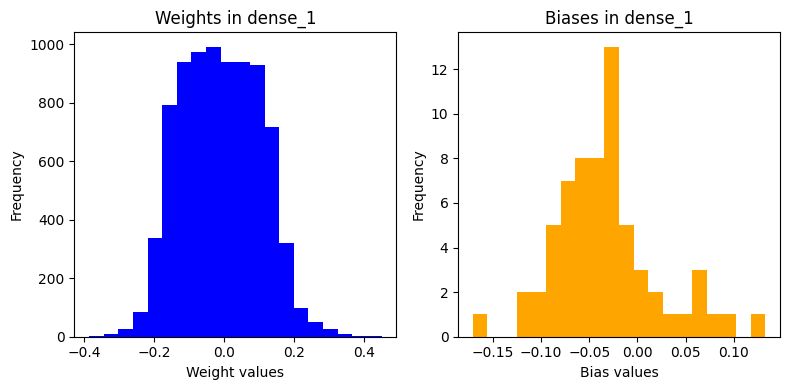

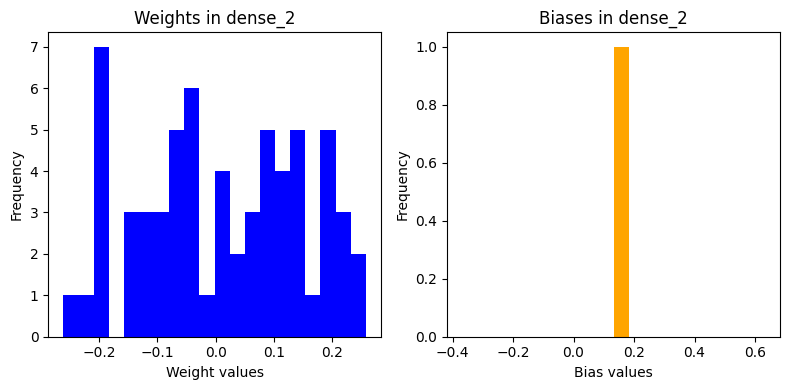

In [8]:
import matplotlib.pyplot as plt

def visualize_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights, biases = layer.get_weights()
            plt.figure(figsize=(8, 4))

            # Visualize weights
            plt.subplot(1, 2, 1)
            plt.title(f"Weights in {layer.name}")
            plt.hist(weights.flatten(), bins=20, color='blue')
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")

            # Visualize biases
            plt.subplot(1, 2, 2)
            plt.title(f"Biases in {layer.name}")
            plt.hist(biases.flatten(), bins=20, color='orange')
            plt.xlabel("Bias values")
            plt.ylabel("Frequency")

            plt.tight_layout()
            plt.show()


visualize_weights(model)
